# Neural Prophet Forecasting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from neuralprophet import NeuralProphet
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error
import warnings
warnings.filterwarnings("ignore")


## Load The Train and Test Daily Delhi Climate data

In [2]:
# Step 1: Load data
train = pd.read_csv('DailyDelhiClimateTrain.csv', parse_dates=['date'])
test = pd.read_csv('DailyDelhiClimateTest.csv', parse_dates=['date'])

# Keep only relevant columns
train = train[['date', 'humidity']].rename(columns={'date': 'ds', 'humidity': 'y'})
test = test[['date', 'humidity']].rename(columns={'date': 'ds', 'humidity': 'y'})

## Train the Model and Add 6-month Seasonality

In [14]:

model = NeuralProphet(
    seasonality_mode='additive',
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    n_changepoints=10,
    quantiles=[0.025, 0.975]  # For 95% prediction interval
)
# Add custom seasonality (~6 months)
model.add_seasonality(name='six_month', period=180, fourier_order=5)


## Fit the model

In [15]:

model.fit(train, freq='D', progress='bar')

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 100


Training: |                                                                                      | 0/? [00:00<…

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number                     for the learning rate finder (229). The results might not be optimal.


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: |                                                                                      | 0/? [00:00<…

,train_loss,reg_loss,MAE,RMSE,Loss,RegLoss,epoch
0,0.846907,0.0,43.944340,56.061825,0.845569,0.0,0
1,0.471413,0.0,31.625538,41.418465,0.470842,0.0,1
2,0.251198,0.0,23.405611,29.760349,0.250458,0.0,2
3,0.149577,0.0,17.760000,21.884382,0.149203,0.0,3
4,0.105393,0.0,14.571625,18.378868,0.105100,0.0,4
...,...,...,...,...,...,...,...
95,0.037912,0.0,9.490037,11.699463,0.037898,0.0,95
96,0.037918,0.0,9.501758,11.745443,0.038013,0.0,96
97,0.037905,0.0,9.489496,11.727061,0.037912,0.0,97
98,0.037921,0.0,9.473346,11.704999,0.037901,0.0,98


## Forecast

In [16]:

future = model.make_future_dataframe(train, periods=len(test), n_historic_predictions=len(train))
forecast = model.predict(future)

forecast_test = forecast.iloc[-len(test):].copy()
forecast_test['ds'] = test['ds'].values  # realign dates

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.937% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.937% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 114 rows at the end with NaNs in 'y' column.


Predicting: |                                                                                    | 0/? [00:00<…

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


## Plot Actual Test Data, Predicted Test Data, and Prediction Interval

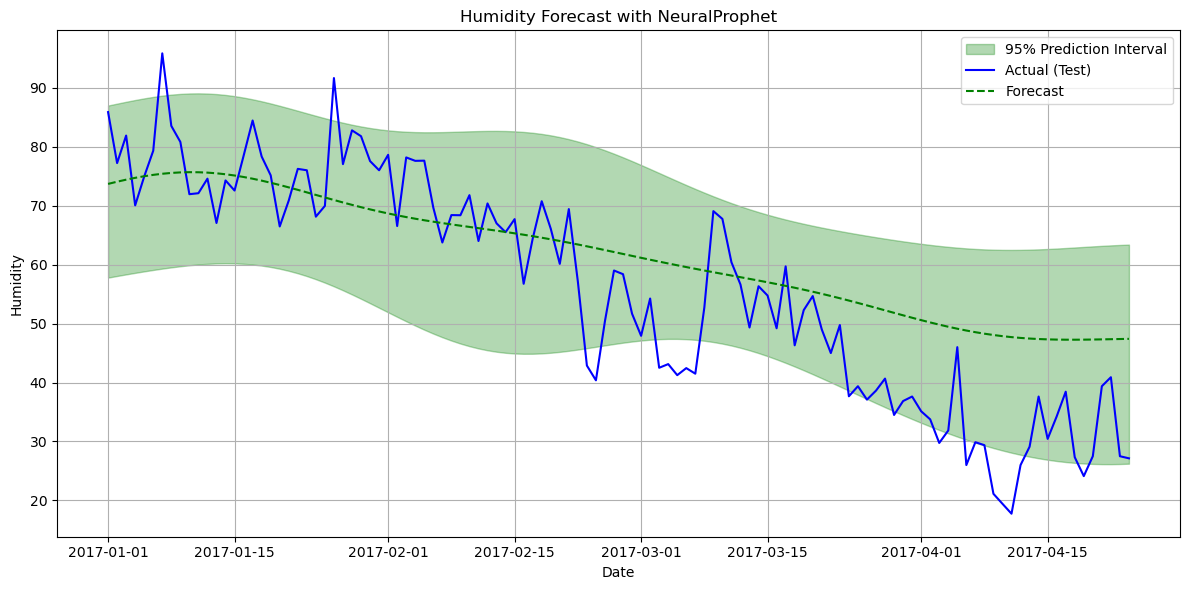

In [17]:

plt.figure(figsize=(12, 6))

plt.fill_between(
    forecast_test['ds'],
    forecast_test['yhat1 2.5%'],
    forecast_test['yhat1 97.5%'],
    color='green',
    alpha=0.3,
    label='95% Prediction Interval'
)

plt.plot(test['ds'], test['y'], label='Actual (Test)', color='blue')
plt.plot(forecast_test['ds'], forecast_test['yhat1'], label='Forecast', color='green', linestyle='--')


plt.title('Humidity Forecast with NeuralProphet')
plt.xlabel('Date')
plt.ylabel('Humidity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("NeuralProphetPLOT.png")
plt.show()


## Compute Errors and Prediction Interval Coverage

In [18]:
y_true = test['y'].values
y_pred = forecast_test['yhat1'].values
lower = forecast_test['yhat1 2.5%'].values
upper = forecast_test['yhat1 97.5%'].values



#MSE
mse = mean_squared_error(y_true, y_pred)

# RMSE
rmse = np.sqrt(mse)

# MAE
mae = mean_absolute_error(y_true,y_pred)

print(f"Test MSE:  {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE:  {mae:.4f}")

coverage = ((y_true >= lower) & (y_true <= upper)).sum() / len(y_true) * 100

print(f"95% Prediction Interval Coverage (NeuralProphet): {coverage:.2f}%")


Test MSE:  145.3144
Test RMSE: 12.0546
Test MAE:  9.6405
95% Prediction Interval Coverage (NeuralProphet): 83.33%


## Interpretability Plots

WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.


Saved pages: 2


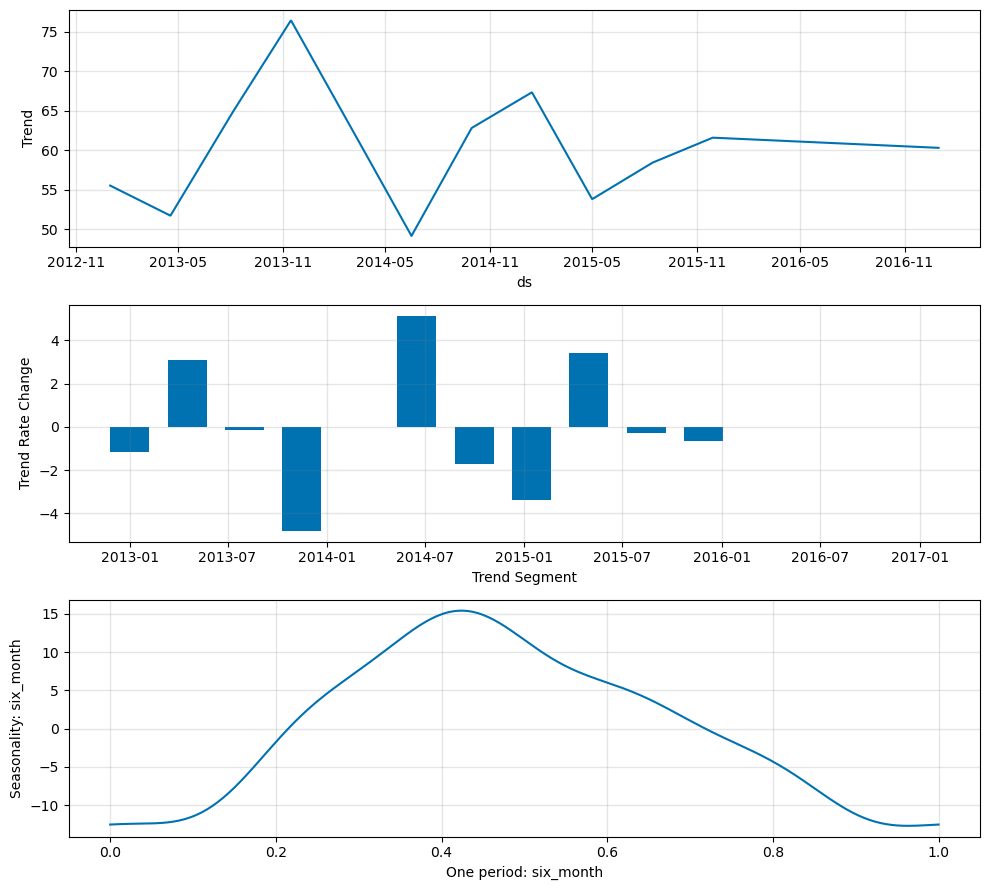

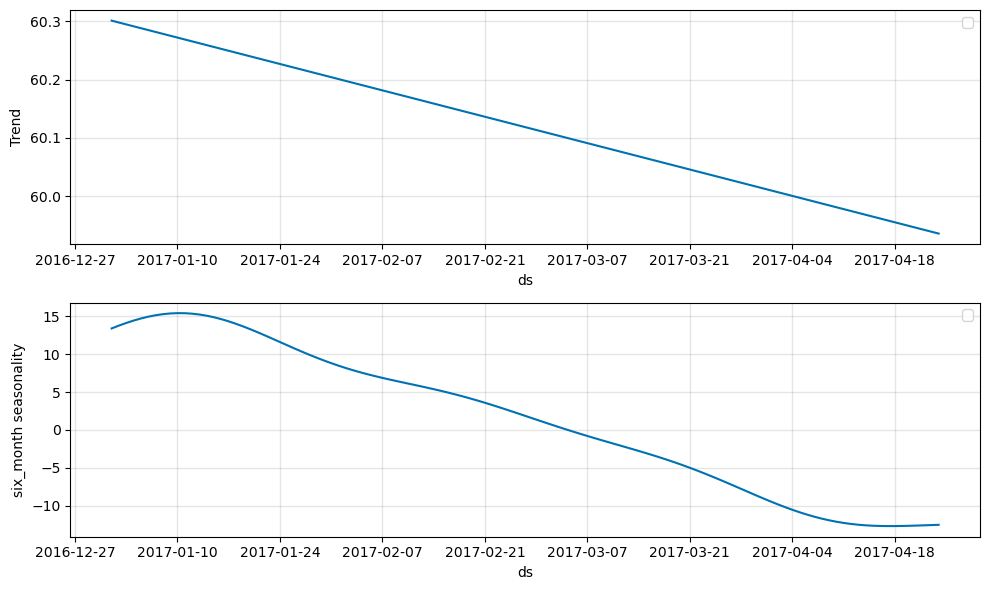

In [19]:
#Change the Output to MatplotLib
try:
    model.set_plotting_backend("matplotlib")   # recent NP versions
except AttributeError:
    model.plotting_backend = "matplotlib"      # older NP versions

figs = model.plot_parameters()
figw=model.plot_components(forecast_test)

#Save all graphs in a Pdf file
from matplotlib.backends.backend_pdf import PdfPages
with PdfPages("neuralprophet_all_plots.pdf") as pdf:
    for num in plt.get_fignums():
        pdf.savefig(plt.figure(num), bbox_inches="tight")

print("Saved pages:", len(plt.get_fignums()))
